In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [3]:
data=pd.read_csv("data up.csv")

In [4]:
data

,Date,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
0,12/31/2002,28.210476,13.495030,6.516891,1.238387,-4.053360
1,1/31/2003,27.424286,13.493538,6.521227,1.235161,-3.288373
2,2/28/2003,32.218421,13.488846,6.521846,1.262143,-3.684400
3,3/31/2003,30.634286,13.492065,6.527099,1.252903,-3.663571
4,4/30/2003,23.991905,13.510243,6.532415,1.258000,-4.161742
...,...,...,...,...,...,...
220,4/30/2021,17.416190,15.866549,7.675462,0.069000,-2.827729
221,5/31/2021,19.760500,15.878174,7.681530,0.058065,-1.116398
222,6/30/2021,16.956818,15.898266,7.686549,0.078000,-1.093716
223,7/31/2021,17.603333,15.918468,7.689882,0.098065,0.611392


In [5]:
data = data.set_index('Date')

In [6]:
data

,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
12/31/2002,28.210476,13.495030,6.516891,1.238387,-4.053360
1/31/2003,27.424286,13.493538,6.521227,1.235161,-3.288373
2/28/2003,32.218421,13.488846,6.521846,1.262143,-3.684400
3/31/2003,30.634286,13.492065,6.527099,1.252903,-3.663571
4/30/2003,23.991905,13.510243,6.532415,1.258000,-4.161742
...,...,...,...,...,...
4/30/2021,17.416190,15.866549,7.675462,0.069000,-2.827729
5/31/2021,19.760500,15.878174,7.681530,0.058065,-1.116398
6/30/2021,16.956818,15.898266,7.686549,0.078000,-1.093716


C:\Users\HP\Desktop\Jupyter_practice\VAR\datlib\plots.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


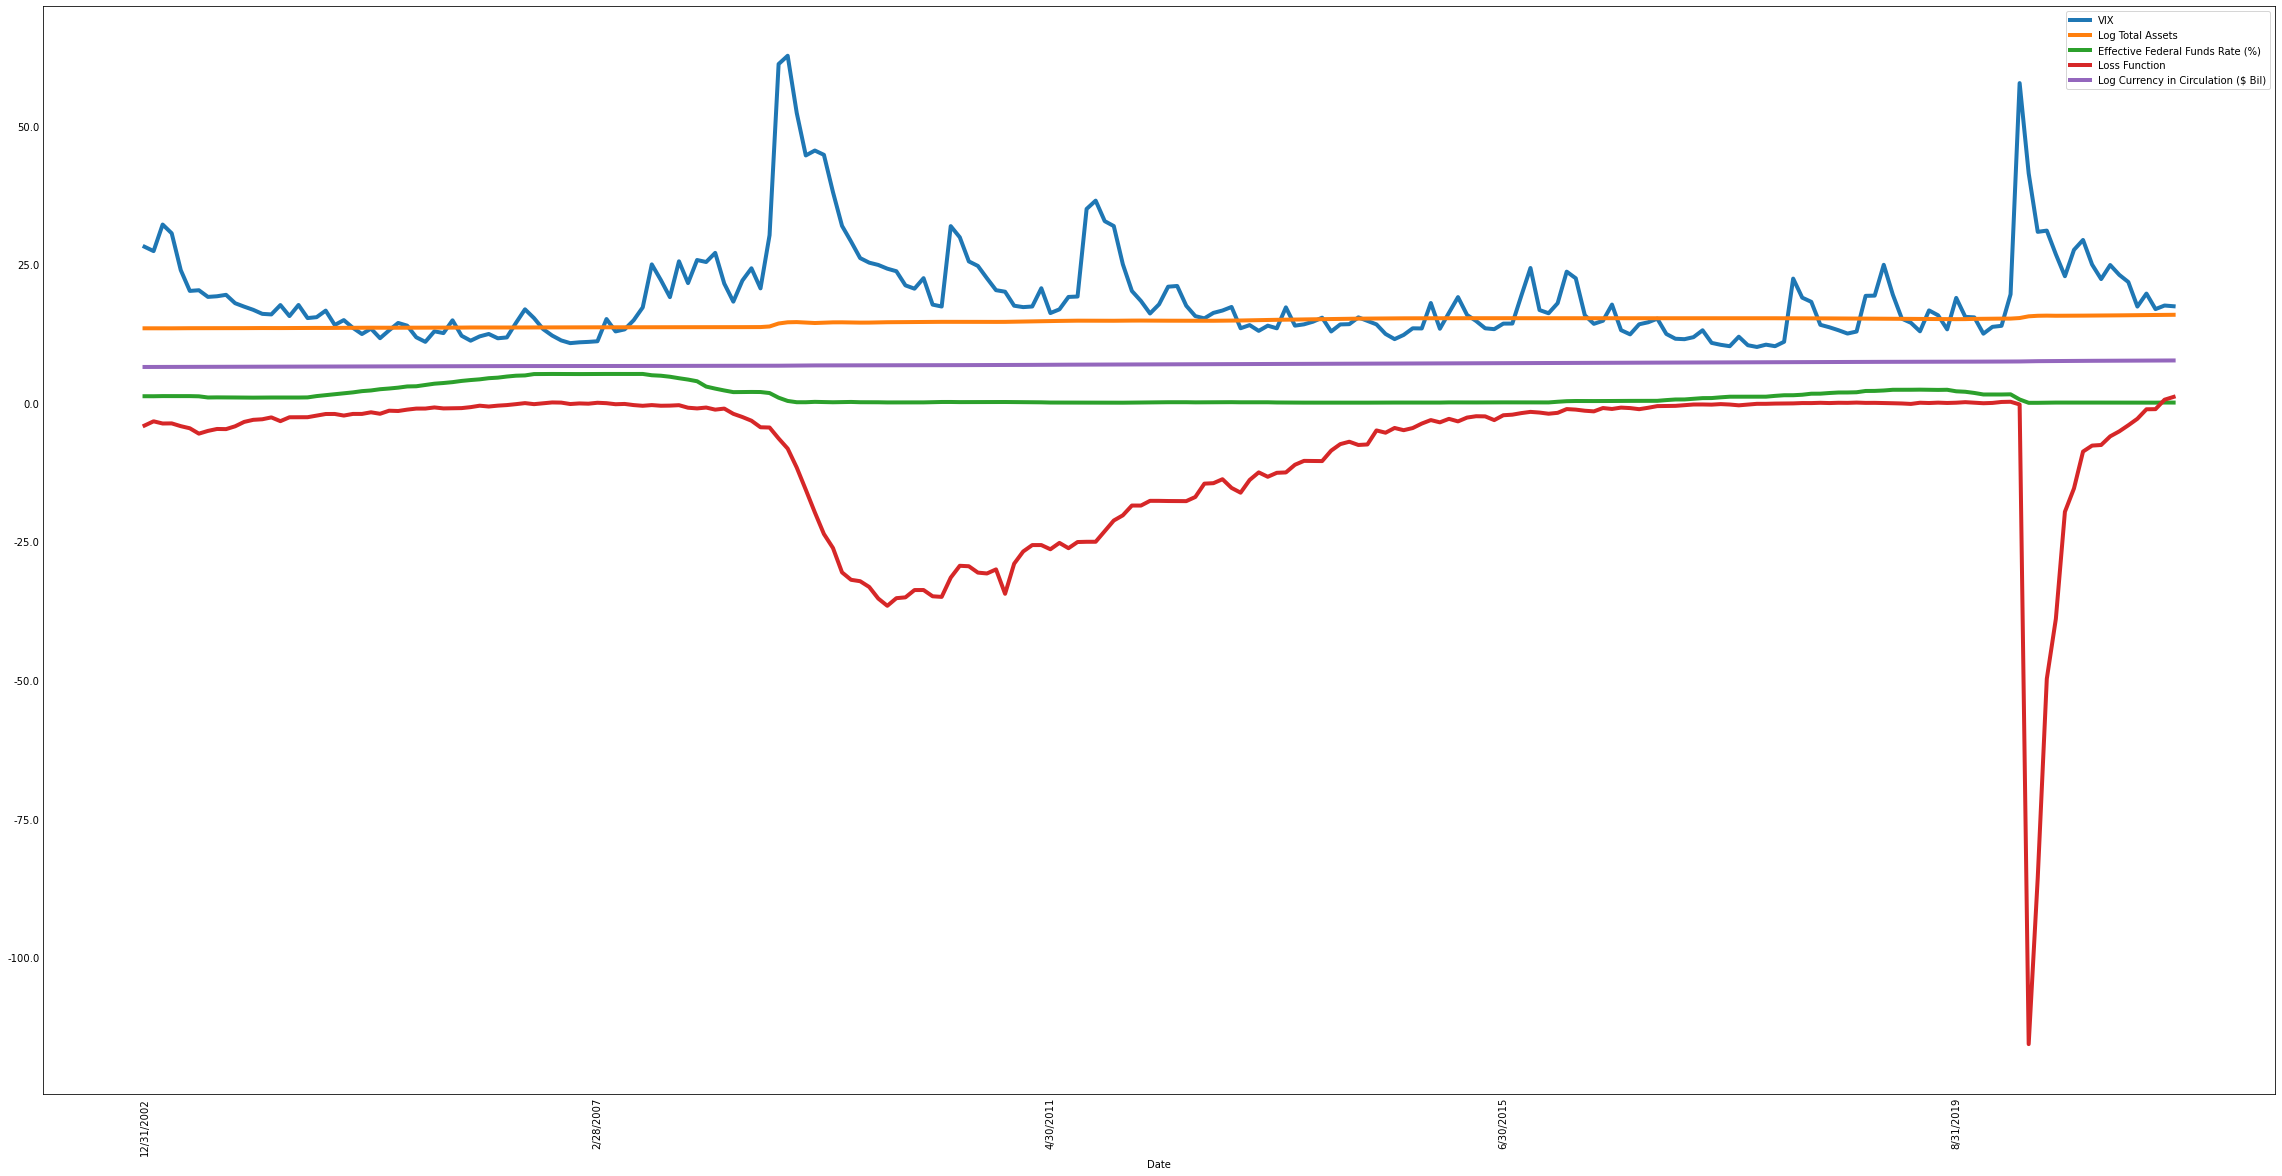

In [7]:
from datlib.plots import * 
plot_variables = ["VIX", "Log Total Assets", "Effective Federal Funds Rate (%)", "Loss Function", "Log Currency in Circulation ($ Bil)"]
plot_lines(data[plot_variables], linewidth=4)

In [8]:
## adf

X = data["VIX"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Effective Federal Funds Rate (%)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Log Total Assets"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Log Currency in Circulation ($ Bil)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Loss Function"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    

ADF Statistic: -3.983914
p-value: 0.001497
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Reject Ho - Time Series is Stationary
ADF Statistic: -2.985282
p-value: 0.036292
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Reject Ho - Time Series is Stationary
ADF Statistic: -0.478814
p-value: 0.896085
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: 2.027487
p-value: 0.998708
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -4.705631
p-value: 0.000082
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Reject Ho - Time Series is Stationary


In [9]:
data_diff = data.diff(year).dropna()
data_diff

,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
12/31/2003,-11.384113,0.045793,0.057056,-0.254194,1.032640
1/31/2004,-11.323286,0.047454,0.049309,-0.238065,0.368954
2/29/2004,-16.220000,0.043829,0.047986,-0.254901,1.102860
3/31/2004,-12.946894,0.043121,0.043676,-0.251290,0.404229
4/30/2004,-8.293333,0.033697,0.042352,-0.254000,1.601901
...,...,...,...,...,...
4/30/2021,-24.037619,0.210753,0.132517,0.020000,112.839893
5/31/2021,-11.136500,0.124273,0.116395,0.008065,84.519025
6/30/2021,-14.162727,0.118755,0.108215,0.000333,48.659408


In [10]:
data_new = data_diff.diff(year).dropna()

In [11]:
data_new

,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
12/31/2004,7.017294,0.016904,-0.006413,1.426129,0.032383
1/31/2005,8.660286,0.012750,0.000492,1.520323,0.889740
2/28/2005,11.930526,0.016558,0.002776,1.749446,-0.450845
3/31/2005,8.385867,0.017146,0.008396,1.878710,1.480530
4/30/2005,7.053810,0.019289,0.007823,2.035000,-0.470287
...,...,...,...,...,...
4/30/2021,-52.542381,-0.260106,0.043371,2.394667,228.571523
5/31/2021,-25.311682,-0.460421,0.008424,2.349032,170.165523
6/30/2021,-29.446273,-0.499225,-0.009767,2.300333,98.492688


In [12]:
X = data_new["VIX"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Effective Federal Funds Rate (%)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Log Total Assets"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Log Currency in Circulation ($ Bil)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Loss Function"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -3.389956
p-value: 0.011306
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -3.092968
p-value: 0.027078
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -3.264237
p-value: 0.016555
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -3.960163
p-value: 0.001634
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -2.885545
p-value: 0.047055
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary


In [13]:
df = data_new
df

,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
12/31/2004,7.017294,0.016904,-0.006413,1.426129,0.032383
1/31/2005,8.660286,0.012750,0.000492,1.520323,0.889740
2/28/2005,11.930526,0.016558,0.002776,1.749446,-0.450845
3/31/2005,8.385867,0.017146,0.008396,1.878710,1.480530
4/30/2005,7.053810,0.019289,0.007823,2.035000,-0.470287
...,...,...,...,...,...
4/30/2021,-52.542381,-0.260106,0.043371,2.394667,228.571523
5/31/2021,-25.311682,-0.460421,0.008424,2.349032,170.165523
6/30/2021,-29.446273,-0.499225,-0.009767,2.300333,98.492688


In [14]:
data_new.to_csv("VIX.csv")

In [15]:
## Johansen test

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
VIX    ::  129.38    > 60.0627   =>   True
Log Total Assets ::  66.89     > 40.1749   =>   True
Log Currency in Circulation ($ Bil) ::  37.12     > 24.2761   =>   True
Effective Federal Funds Rate (%) ::  16.2      > 12.3212   =>   True
Loss Function ::  7.14      > 4.1296    =>   True


In [16]:
##Testing Causation using Granger’s Causality Test

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data_new, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data_new[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,VIX_x,Log Total Assets_x,Log Currency in Circulation ($ Bil)_x,Effective Federal Funds Rate (%)_x,Loss Function_x
VIX_y,1.0,0.0000,0.0000,0.0,0.0000
Log Total Assets_y,0.0,1.0000,0.0003,0.0,0.1826
Log Currency in Circulation ($ Bil)_y,0.0,0.0000,1.0000,0.0,0.0000
Effective Federal Funds Rate (%)_y,0.0,0.0000,0.0000,1.0,0.0000
Loss Function_y,0.0,0.1308,0.0000,0.0,1.0000


In [17]:
var = VAR(df)

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [18]:
x= var.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,2.179,2.266,8.840,2.214
1,-7.134,-6.616,0.0007976,-6.924
2,-8.294,-7.344*,0.0002502,-7.909
3,-8.477,-7.095,0.0002086,-7.917
4,-8.526,-6.712,0.0001992,-7.791
5,-8.900,-6.654,0.0001376,-7.990
6,-8.957,-6.279,0.0001308,-7.872
7,-9.024,-5.913,0.0001235,-7.763
8,-9.205,-5.663,0.0001042,-7.770
9,-10.14,-6.163,4.169e-05,-8.527


In [19]:
results = var.fit(14)
#We can check the summary of the model by.
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Mar, 2022
Time:                     19:30:34
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -6.25923
Nobs:                     187.000    HQIC:                  -9.90769
Log likelihood:           187.053    FPE:                5.06528e-06
AIC:                     -12.3932    Det(Omega_mle):     1.01324e-06
--------------------------------------------------------------------
Results for equation VIX
                                             coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                                           0.378062         0.524855            0.720           0.471
L1.VIX                                          0.869247         

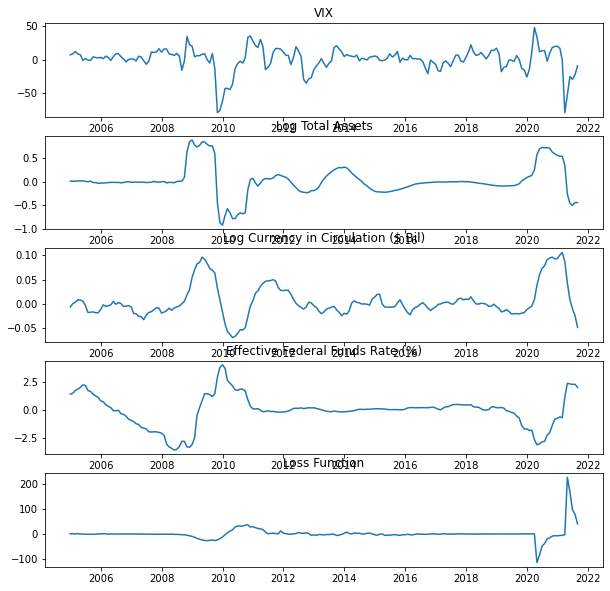

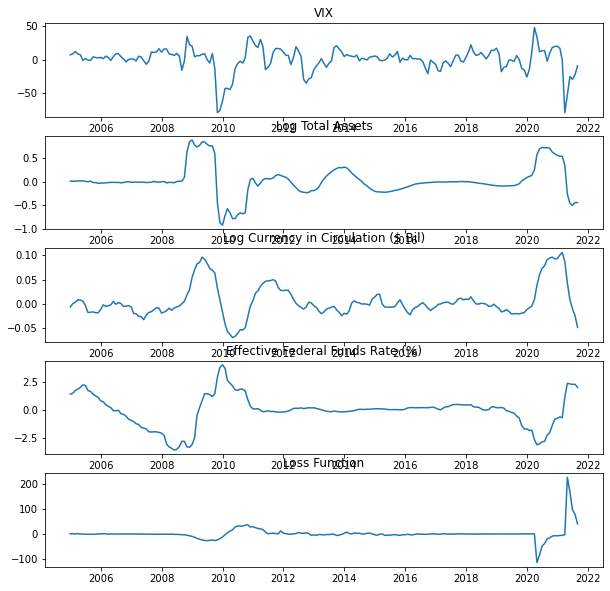

In [20]:
results.plot()

In [21]:
train_df=df[:-12]
test_df=df[-12:]

In [22]:
model = VAR(train_df)

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [23]:
from statsmodels.tsa.statespace.varmax import VARMAX

var_model = VARMAX(train_df, order=(14,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                                              Statespace Model Results                                                                             
Dep. Variable:     ['VIX', 'Log Total Assets', 'Log Currency in Circulation ($ Bil)', 'Effective Federal Funds Rate (%)', 'Loss Function']   No. Observations:                  189
Model:                                                                                                                             VAR(14)   Log Likelihood                -943.494
                                                                                                                               + intercept   AIC                           2626.989
Date:                                                                                                                     Tue, 29 Mar 2022   BIC                           3826.435
Time:                                                                                               

In [24]:
def adjust(val, length= 6): return str(val).ljust(length)

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

NameError: name 'model_fitted' is not defined

In [ ]:
model = VAR(df)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

In [ ]:
x = model.select_order(maxlags=29)
x.summary()

In [ ]:
model_fitted = model.fit(29)
model_fitted.summary()

##Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic


Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). What does this mean to us? If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series. So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series. Alright, coming back to topic. A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.Durbin Watson Statistic - FormulaThe value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [ ]:
df.to_csv("VIX.csv")

In [ ]:
results = var.fit(32)
#We can check the summary of the model by.
results.summary()